# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import os
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig

# Set config

In [3]:
llm_config = LLMConfig(
    vocab_size=512,
    context_size=64,
    dim_emb=512,
    num_layers=4,
    num_heads=16
)

train_config = TrainingConfig(
    retrain_tokenizer=True,
    batch_size=128,
    learning_rate=1e-4,
    max_steps=100,
    log_frequency=1
)

# Prepare tokenizer and dataset


In [19]:
input_file = "../data/shakespeare/alllines.txt"
output_path = "../data/shakespeare"

tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file) or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size, tokenizer_model_file)

tokenizer = Tokenizer(tokenizer_model_file)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=../data/shakespeare/alllines.txt --vocab_size=512 --model_prefix=../data/shakespeare/tokenizer --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/shakespeare/alllines.txt
  input_format: 
  model_prefix: ../data/shakespeare/tokenizer
  model_type: UNIGRAM
  vocab_size: 512
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_

In [20]:
sentence = "The role of the tokenizer is to build a mapping between subwords and token indices"
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁r', 'o', 'le', '▁of', '▁the', '▁to', 'ke', 'n', 'i', 'z', 'er', '▁is', '▁to', '▁b', 'u', 'il', 'd', '▁a', '▁ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁', 's', 'u', 'b', 'w', 'or', 'd', 's', '▁and', '▁to', 'ke', 'n', '▁in', 'd', 'ice', 's']


In [21]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

ds_train.get_batch(batch_size=1)

(tensor([[ 19,  25,  16,  94,   4, 114, 281, 204, 385,  15, 157, 186,  11, 292,
           24, 383,  57, 120, 143,  19, 409,   5, 150,   9,  11, 397,  24, 113,
          160, 313, 223,  80, 215,   7,  16,  37,   8, 265, 121,   4, 403, 439,
           24, 482,  44,  73, 191, 277,   9,  48,  76,   4,   6, 291,  38,   6,
          508,  13,  45,  14, 252, 116,  34,  64]], dtype=torch.int32),
 tensor([[ 25,  16,  94,   4, 114, 281, 204, 385,  15, 157, 186,  11, 292,  24,
          383,  57, 120, 143,  19, 409,   5, 150,   9,  11, 397,  24, 113, 160,
          313, 223,  80, 215,   7,  16,  37,   8, 265, 121,   4, 403, 439,  24,
          482,  44,  73, 191, 277,   9,  48,  76,   4,   6, 291,  38,   6, 508,
           13,  45,  14, 252, 116,  34,  64,  34]]))

# Define model


In [22]:
model = LLM(
    vocab_size=llm_config.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
)

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,d}")
print(model)

total params: 8,927,744
learnable params: 8,927,744
LLM(
  (token_embedding): Embedding(512, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=512, out_features=512, bias=False)
        (projection_key): Linear(in_features=512, out_features=512, bias=False)
        (projection_value): Linear(in_features=512, out_features=512, bias=False)
        (projection_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
          (3): Linear(in_features=512, out_features=

# Train model


In [23]:
loss_history = train(
    model,
    ds_train,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    log_every=train_config.log_frequency,
)

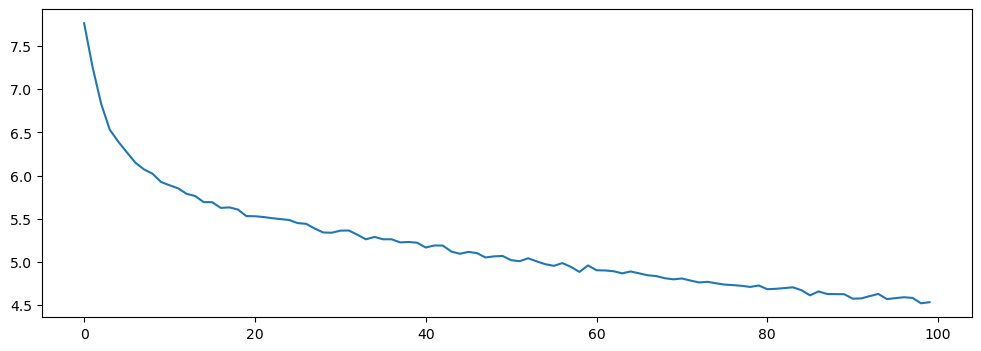

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])

# Play around

In [25]:
# empty prompt to generate random stuff
prompt = torch.zeros((1, llm_config.context_size), dtype=torch.long)
out = model.generate(prompt, max_seq_len=50)

In [26]:
tokenizer.decode(out)

'ENO a my lords ment in and proon, a noidL, Good greatp thee, Gu so it arry to be, ifilingvar as of bid you proing my So I'